In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchaudio
from ae_model import CNNAutoencoder
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import datetime

from custom_audio_dataset import BirdAudioDataset

PRETRAINED_PATH = "theta_run_birds/exp_dim10_files6/conv_autoencoder.pth"

# AUDIO_FILES = ["20210816T063139-0500_Rec.wav", "20210815T063139-0500_Rec.wav", "20210815T170000-0500_Rec.wav"]
AUDIO_FILES = ["20210815T063139-0500_Rec.wav"]
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

bad = BirdAudioDataset(
    AUDIO_FILES, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device
)

model = CNNAutoencoder().to(device=device)
model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=torch.device("cpu")))

Using cpu device
Loaded 1 audio file(s)


<All keys matched successfully>

In [3]:
def plot_recons(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    num_frames = end_frame - start_frame

    # Set up grayscale figure
    fig_scale = 3
    fig, axes = plt.subplots(nrows=2, ncols=num_frames, figsize=(num_frames * fig_scale, 2 * fig_scale))
    rows = ["Original", "Recon"]
    for ax, row in zip(axes[:, 0], rows):
        ax.set_ylabel(row, rotation=0, size="large")
    fig.tight_layout()
    plt.gray()
    
    # Add subplot for each original spectrogram and reconstruction
    for i, (img, _) in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        
        img = img.to(device)
        recon, _ = model(img)

        axes[0][i].imshow(img[0][0], cmap="plasma")
        axes[1][i].imshow(recon[0][0], cmap="plasma")
    
    print()

    # Save figure
    figure_save_path = "recon.png"
    plt.savefig(figure_save_path)
    print(f"Saved figure at path: {figure_save_path}")

In [4]:
import os
import numpy as np

def save_audio(model, device, start_frame, end_frame, frequency_cropped=False):

    time_series_imgs = np.array([])
    time_series_recons = np.array([])

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    
    audio_save_path = "sounds"
    os.makedirs(audio_save_path, exist_ok=True)
    
    # Save audio for each original spectrogram and reconstruction
    for i, (img, _) in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        recon, _ = model(img)

        if frequency_cropped:
            frequency_padding = (0, 0, 64, 0)
            img = torch.nn.functional.pad(img, frequency_padding)
            recon = torch.nn.functional.pad(recon, frequency_padding)

        time_series_img = librosa.feature.inverse.mel_to_audio(
            img[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )
        time_series_recon = librosa.feature.inverse.mel_to_audio(
            recon[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )

        time_series_imgs = np.concatenate((time_series_imgs, time_series_img))
        time_series_recons = np.concatenate((time_series_recons, time_series_recon))

        sf.write(f"{audio_save_path}/audio_img{i}.wav", time_series_img, SAMPLE_RATE)
        sf.write(f"{audio_save_path}/audio_recon{i}.wav", time_series_recon, SAMPLE_RATE)

    sf.write(f"{audio_save_path}/audio_img_tog.wav", time_series_imgs, SAMPLE_RATE)
    sf.write(f"{audio_save_path}/audio_recon_tog.wav", time_series_recons, SAMPLE_RATE)
        
    print()
    print(f"Saved audio files at path: {audio_save_path}")

In [5]:
def to_timestamp(index):
    return str(datetime.timedelta(seconds=index))

In [6]:
def get_embeddings_and_losses(model, device, start_frame, end_frame):
    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)

    losses = []
    timestamps = []
    embeddings = []

    # Apply model to each sample to get embeddings and losses
    for i, (img, index) in enumerate(dataloader):
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')

        img = img.to(device)

        recon, embedding = model(img)
        loss_fn = nn.MSELoss()
        loss = loss_fn(recon, img)

        embeddings.append(embedding[0].detach().numpy())
        losses.append(loss.item())
        timestamps.append(to_timestamp(index.item()))
    
    print()

    return embeddings, losses, timestamps

In [7]:
with torch.no_grad():
    embeddings, losses, timestamps = get_embeddings_and_losses(model, device, 0, len(bad))
    losses = np.array(losses)
    timestamps = np.array(timestamps)
    embeddings = np.array(embeddings)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Processing sample: 24348/24348


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
embeddings = pca.fit_transform(embeddings)

In [28]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(data={'Dim. 1': embeddings[:, 0], 'Dim. 2': embeddings[:, 1], 'Dim. 3': embeddings[:, 2], 'Log-Loss': np.log10(losses), 'Timestamp': timestamps})
fig = px.scatter_3d(df, x='Dim. 1', y='Dim. 2', z='Dim. 3', color="Log-Loss", hover_data=["Timestamp"], title="Dimension-Reduced Embeddings of One-Second Audio Samples")
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.show()

In [23]:
def get_anomalies(losses):
    for loss, timestamp in zip(losses, timestamps):
        if loss > 0.2e6:
            print(timestamp)

In [24]:
with torch.no_grad():
    get_anomalies(losses)

1:11:18
1:11:19
1:11:22
1:11:23
3:26:32
3:26:41
3:43:23
3:43:25
3:43:26
3:43:27
3:43:28
3:43:30
3:43:31
4:45:46
5:16:25
5:52:40
5:52:41
5:52:42
5:52:43
5:52:46
5:52:47
5:52:48
5:52:49
5:52:50
5:52:51
5:52:52
5:52:53
5:54:07
5:54:08
5:54:09
5:54:10
5:54:11
5:54:12
5:54:17
5:54:21


Processing sample: 10/10


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.



Saved figure at path: recon.png


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.



Processing sample: 10/10
Saved audio files at path: sounds


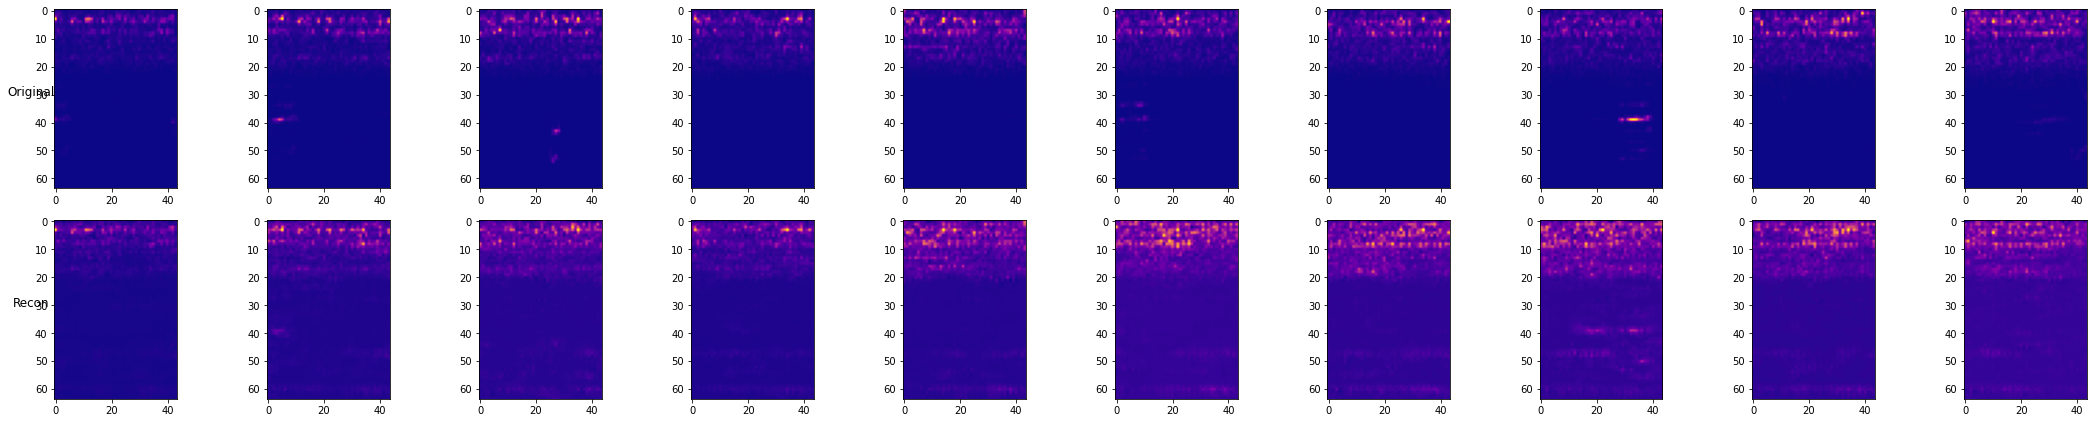

In [29]:
with torch.no_grad():
    plot_recons(model, device, 0, 10)

with torch.no_grad():
    save_audio(model, device, 0, 10)